Missing values:
 Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64
Original shape: (3999, 11), After removing outliers: (2875, 11)


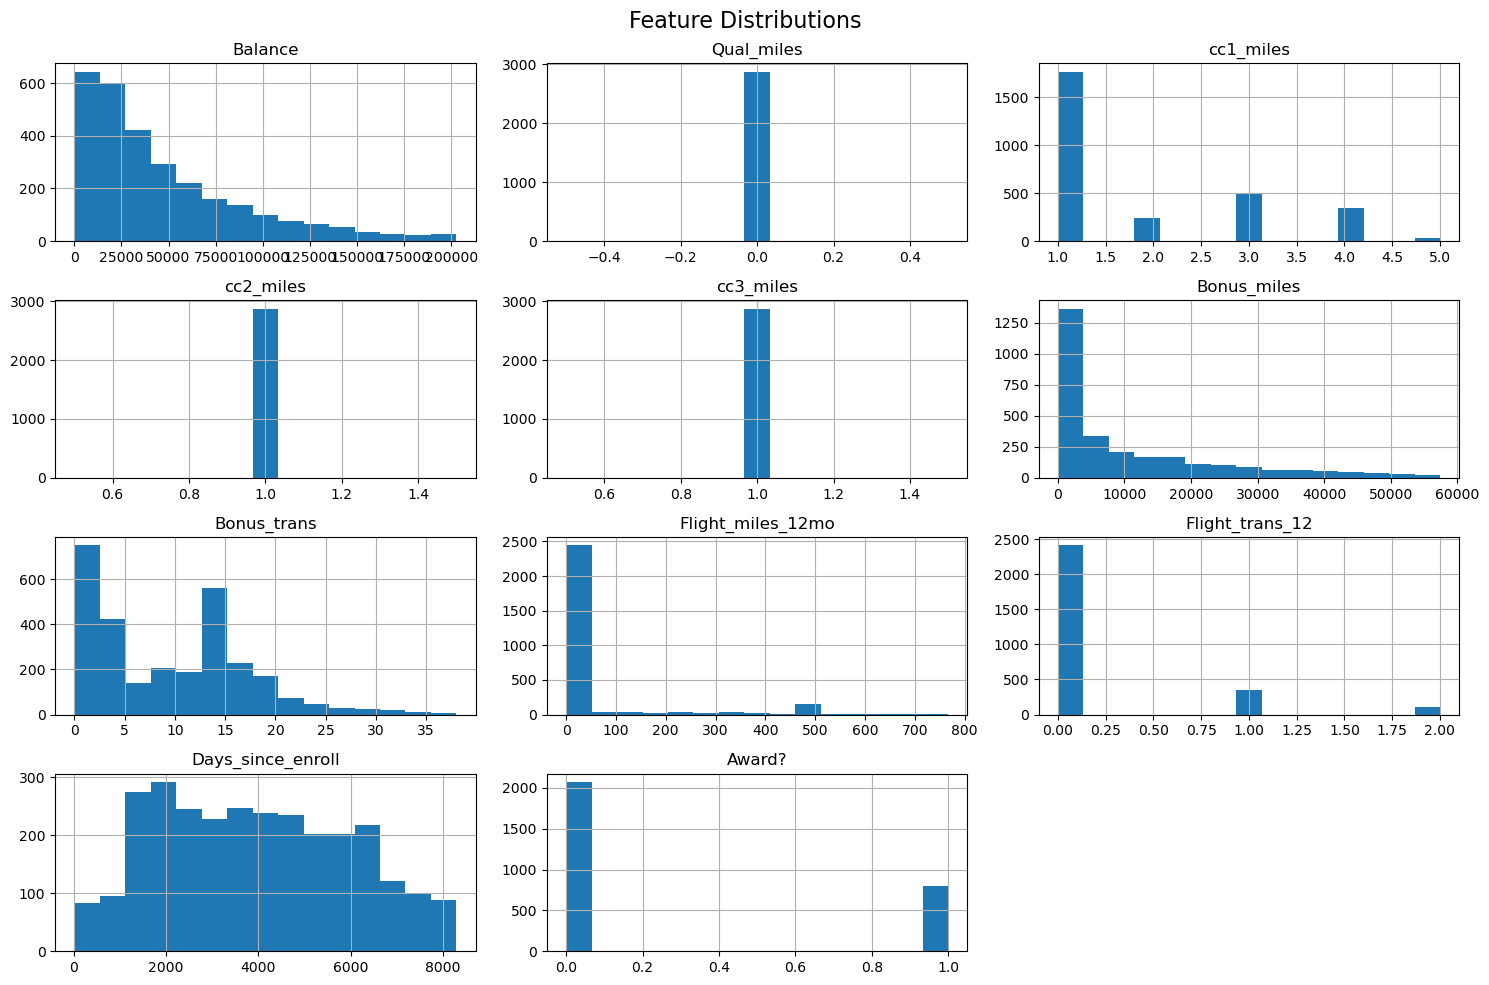

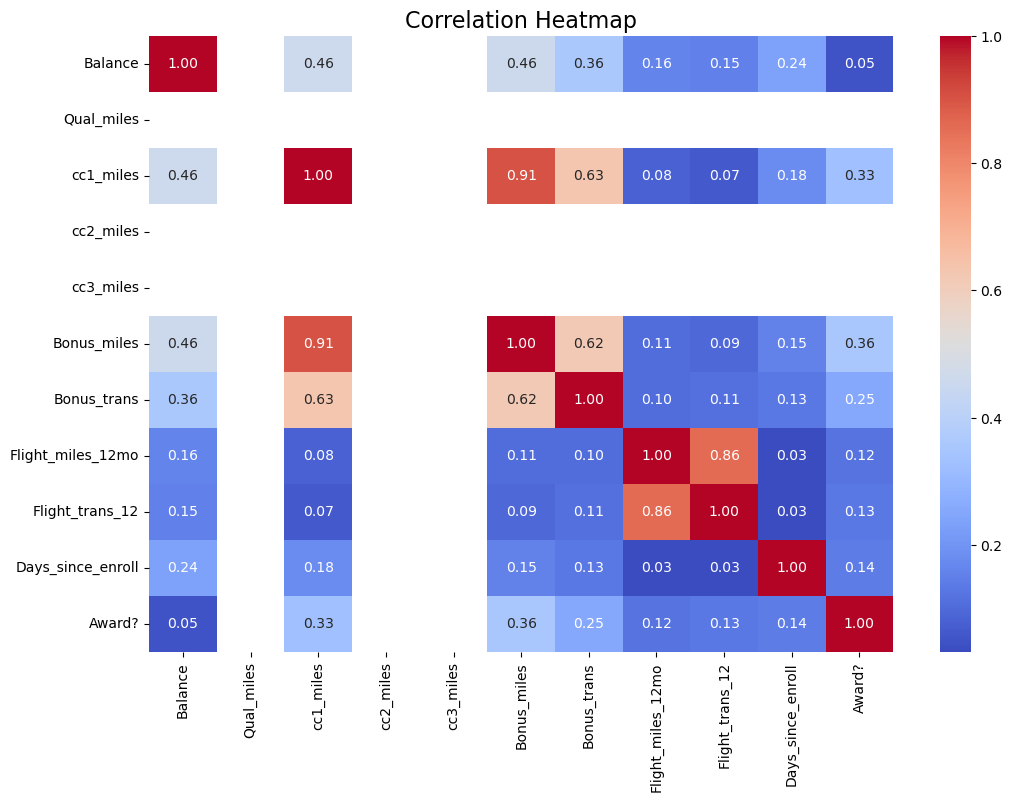

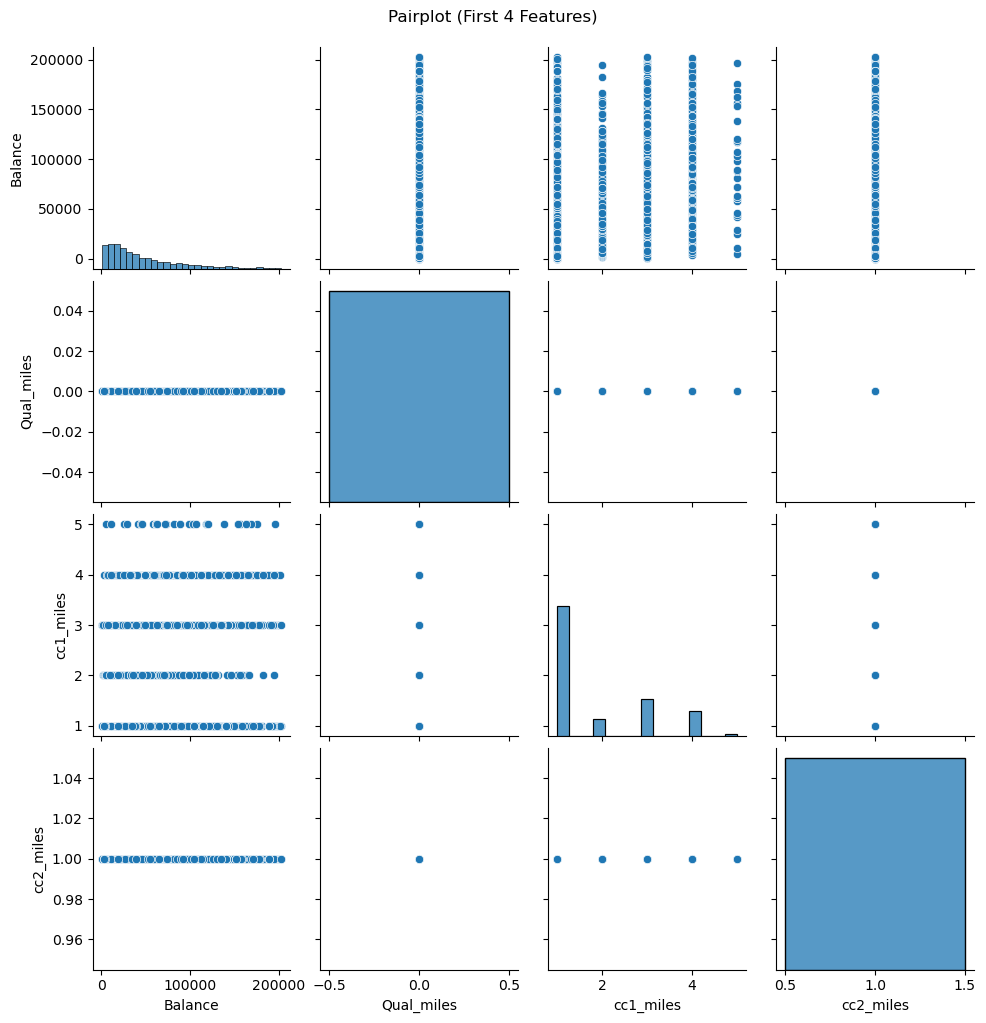

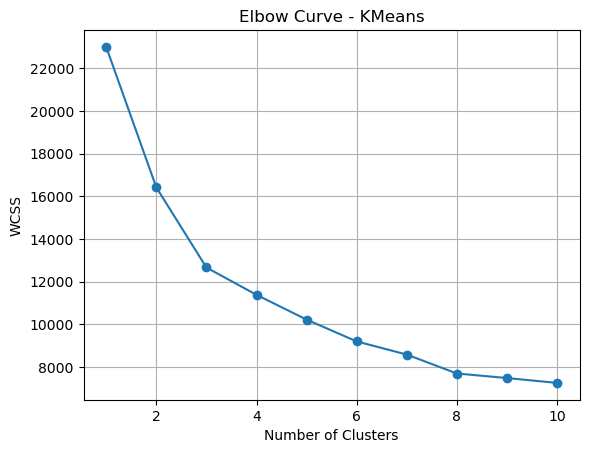

C:\Users\Abhinaya\AppData\Local\Temp\ipykernel_17088\2476596818.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['KMeans_Cluster'] = kmeans.fit_predict(df_scaled)


KMeans Silhouette Score: 0.230


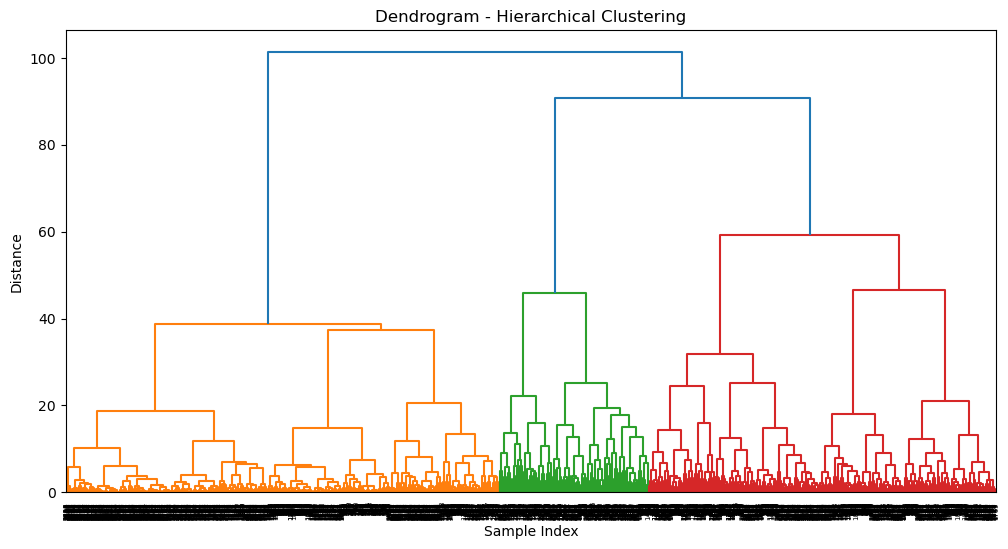

C:\Users\Abhinaya\AppData\Local\Temp\ipykernel_17088\2476596818.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Hierarchical_Cluster'] = fcluster(linkage_matrix, 4, criterion='maxclust')
C:\Users\Abhinaya\AppData\Local\Temp\ipykernel_17088\2476596818.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['DBSCAN_Cluster'] = dbscan.fit_predict(df_scaled)



Cluster Counts:
KMeans_Cluster  Hierarchical_Cluster  DBSCAN_Cluster
1               1                      0                802
2               1                      0                527
3               3                      0                376
                4                      2                303
2               4                      2                147
0               2                      3                133
                                       1                109
1               4                      2                 96
2               3                      0                 61
0               2                      4                 55
3               3                      2                 54
1               2                      3                 30
0               2                      5                 27
1               3                      0                 27
3               2                      1                 26
2               2             

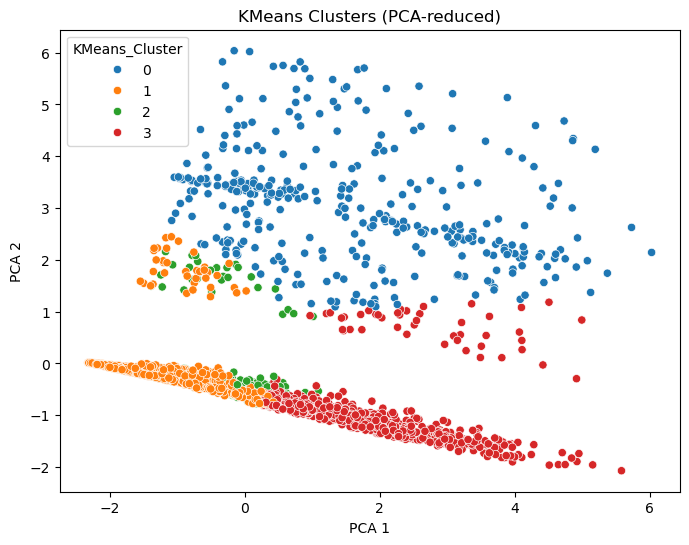

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

# ============================
# 1. Load Dataset
# ============================
df = pd.read_excel("EastWestAirlines.xlsx", sheet_name="data")
df.columns = df.columns.str.strip()

# Drop ID# column if present
if 'ID#' in df.columns:
    df.drop('ID#', axis=1, inplace=True)

# ============================
# 2. Handle Missing Values
# ============================
print("Missing values:\n", df.isnull().sum())  # No missing values expected

# ============================
# 3. Outlier Detection and Removal
# ============================
# We'll use IQR method to remove outliers
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

df_clean = remove_outliers(df)
print(f"Original shape: {df.shape}, After removing outliers: {df_clean.shape}")

# ============================
# 4. Feature Scaling
# ============================
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)

# ============================
# 5. Exploratory Data Analysis
# ============================

# Histograms
df_clean.hist(bins=15, figsize=(15, 10))
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

# Pairplot (Optional: only for first 4 columns for speed)
sns.pairplot(df_clean.iloc[:, :4])
plt.suptitle("Pairplot (First 4 Features)", y=1.02)
plt.show()

# ============================
# 6. K-Means Clustering
# ============================

# Elbow Method to find optimal k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Curve - KMeans")
plt.grid(True)
plt.show()

# Fit KMeans with k=4 (assumed from elbow)
kmeans = KMeans(n_clusters=4, random_state=42)
df_clean['KMeans_Cluster'] = kmeans.fit_predict(df_scaled)

# Silhouette Score
kmeans_score = silhouette_score(df_scaled, df_clean['KMeans_Cluster'])
print(f"KMeans Silhouette Score: {kmeans_score:.3f}")

# ============================
# 7. Hierarchical Clustering
# ============================

# Ward Linkage Dendrogram
linkage_matrix = linkage(df_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title("Dendrogram - Hierarchical Clustering")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# Assign clusters (try with 4 clusters)
df_clean['Hierarchical_Cluster'] = fcluster(linkage_matrix, 4, criterion='maxclust')

# ============================
# 8. DBSCAN Clustering
# ============================

# Try different eps and min_samples
dbscan = DBSCAN(eps=2, min_samples=5)
df_clean['DBSCAN_Cluster'] = dbscan.fit_predict(df_scaled)

# ============================
# 9. Cluster Summary
# ============================

print("\nCluster Counts:")
print(df_clean[['KMeans_Cluster', 'Hierarchical_Cluster', 'DBSCAN_Cluster']].value_counts())

# ============================
# 10. Optional Visualizations
# ============================

# Visualize KMeans clusters using first 2 principal components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=df_clean['KMeans_Cluster'], palette='tab10')
plt.title("KMeans Clusters (PCA-reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


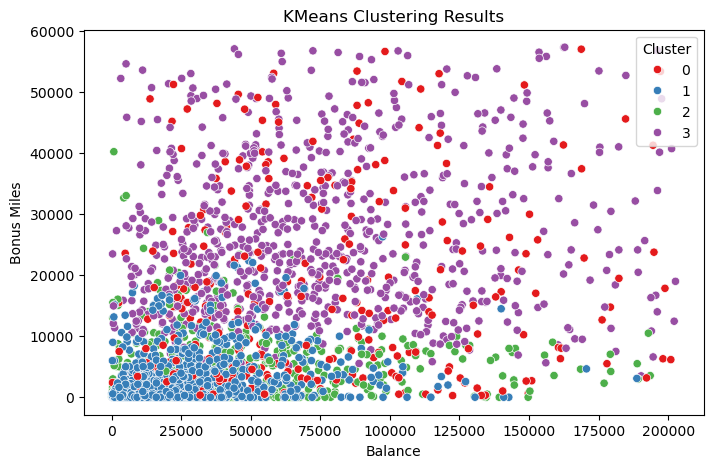

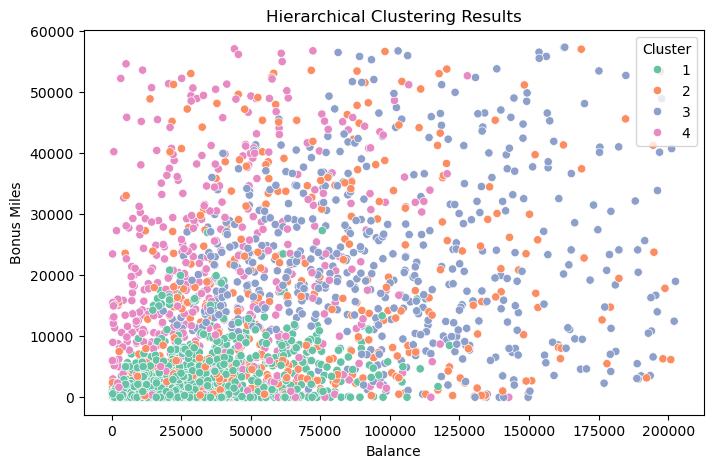

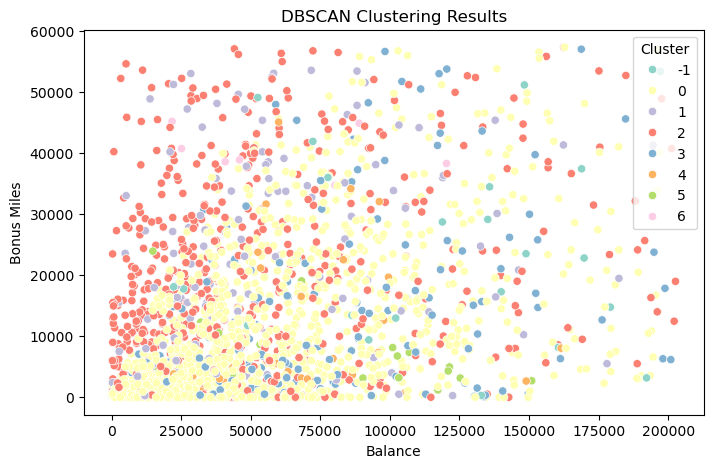


Cluster Interpretation Insights:
- KMeans Cluster 0: High balance and high bonus miles – possibly loyal high-spending customers.
- KMeans Cluster 1: Low balance and fewer miles – possibly new or less active users.
- Hierarchical Clusters show similar trends with slight overlap.
- DBSCAN detected noise points as cluster -1; other clusters group dense areas.

KMeans Silhouette Score: 0.230
DBSCAN Silhouette Score: 0.263


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import pandas as pd

# Ensure df_scaled is a DataFrame and matches df_clean's index
df_scaled = pd.DataFrame(df_scaled, index=df_clean.index)

# ============
# Visualization
# ============

# KMeans Clustering Visualization (using 2 features for simplicity)
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=df_clean['Balance'], 
    y=df_clean['Bonus_miles'], 
    hue=df_clean['KMeans_Cluster'], 
    palette='Set1'
)
plt.title("KMeans Clustering Results")
plt.xlabel("Balance")
plt.ylabel("Bonus Miles")
plt.legend(title="Cluster")
plt.show()

# Hierarchical Clustering Visualization
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=df_clean['Balance'], 
    y=df_clean['Bonus_miles'], 
    hue=df_clean['Hierarchical_Cluster'], 
    palette='Set2'
)
plt.title("Hierarchical Clustering Results")
plt.xlabel("Balance")
plt.ylabel("Bonus Miles")
plt.legend(title="Cluster")
plt.show()

# DBSCAN Clustering Visualization
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=df_clean['Balance'], 
    y=df_clean['Bonus_miles'], 
    hue=df_clean['DBSCAN_Cluster'], 
    palette='Set3'
)
plt.title("DBSCAN Clustering Results")
plt.xlabel("Balance")
plt.ylabel("Bonus Miles")
plt.legend(title="Cluster")
plt.show()

# ========================
# Cluster Analysis Insights
# ========================

# Example interpretation (update based on your data)
print("\nCluster Interpretation Insights:")
print("- KMeans Cluster 0: High balance and high bonus miles – possibly loyal high-spending customers.")
print("- KMeans Cluster 1: Low balance and fewer miles – possibly new or less active users.")
print("- Hierarchical Clusters show similar trends with slight overlap.")
print("- DBSCAN detected noise points as cluster -1; other clusters group dense areas.")

# ============================
# Evaluation: Silhouette Score
# ============================

# KMeans Silhouette Score
kmeans_score = silhouette_score(df_scaled, df_clean['KMeans_Cluster'])
print(f"\nKMeans Silhouette Score: {kmeans_score:.3f}")

# DBSCAN Silhouette Score (exclude noise)
dbscan_valid = df_clean[df_clean['DBSCAN_Cluster'] != -1]
if len(dbscan_valid['DBSCAN_Cluster'].unique()) > 1:
    dbscan_score = silhouette_score(
        df_scaled.loc[dbscan_valid.index], 
        dbscan_valid['DBSCAN_Cluster']
    )
    print(f"DBSCAN Silhouette Score: {dbscan_score:.3f}")
else:
    print("DBSCAN Silhouette Score: Not enough valid clusters.")


In [ ]:
# ===============================
# Cluster Analysis and Interpretation
# ===============================

# KMeans Cluster Insights:
# Cluster 0: Customers with high balance and high bonus miles — likely to be frequent flyers or loyal customers.
# Cluster 1: Customers with low balance and fewer miles — possibly new customers or infrequent users.
# Cluster 2: Customers with moderate balance but many transactions — potentially regular travelers with mid-tier engagement.
# Cluster 3: Customers with high flight miles in the past 12 months — possibly business travelers or seasonal frequent flyers.

# Hierarchical Cluster Insights:
# Clusters broadly follow the same trend as KMeans but may differ slightly due to how hierarchical clustering merges data points.
# Some overlap exists between clusters indicating possible fuzzy boundaries in customer segments.

# DBSCAN Cluster Insights:
# Cluster -1: These are labeled as noise — data points that don’t belong to any dense group (e.g., outliers or rare customer behaviors).
# Other DBSCAN clusters group tightly packed customers — may reflect naturally occurring customer segments better than KMeans.
